## MedSam model

In [ ]:
import os
import numpy as np
import torch
import torch.nn.functional as F
from skimage import io, transform
import matplotlib.pyplot as plt
from PIL import Image
from natsort import natsorted
from segment_anything import sam_model_registry

# Visualization functions
def show_mask(mask, ax):
    color = np.array([251/255, 252/255, 30/255, 0.6])  # Yellow with transparency
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='blue', facecolor=(0, 0, 0, 0), lw=2))

@torch.no_grad()
def medsam_inference(medsam_model, img_embed, box_1024):
    box_torch = torch.as_tensor(box_1024, dtype=torch.float, device=img_embed.device)
    sparse_embeddings, dense_embeddings = medsam_model.prompt_encoder(
        points=None,
        boxes=box_torch[None, None, :],
        masks=None,
    )
    low_res_logits, _ = medsam_model.mask_decoder(
        image_embeddings=img_embed,
        image_pe=medsam_model.prompt_encoder.get_dense_pe(),
        sparse_prompt_embeddings=sparse_embeddings,
        dense_prompt_embeddings=dense_embeddings,
        multimask_output=False,
    )
    # Output mask at 256x256 resolution and resize to 1024x1024
    low_res_pred = torch.sigmoid(low_res_logits)
    low_res_pred = F.interpolate(low_res_pred, size=(1024, 1024), mode="bilinear", align_corners=False)
    return (low_res_pred.squeeze().cpu().numpy() > 0.5).astype(np.uint8)

## Loading Checkpoints and Generate Segmented Image

In [ ]:
# Load MedSAM model and image
MedSAM_CKPT_PATH = r"PATH\TO\medsam_vit_b.pth"

#uncomment to download

#!wget -O medsam_vit_b.pth "https://drive.google.com/uc?export=download&id=1ETWmi4AiniJeWOt6HAsYgTjYv_fkgzoN"
#MedSAM_CKPT_PATH = "medsam_vit_b.pth"

device = "cpu"

# Load the checkpoint on CPU
checkpoint = torch.load(MedSAM_CKPT_PATH, map_location=torch.device('cpu'))
medsam_model = sam_model_registry['vit_b']()
medsam_model.load_state_dict(checkpoint)
medsam_model = medsam_model.to(device)
medsam_model.eval()

# Load and preprocess the image
img_path = "PATH/to/image"
img_np = io.imread(img_path)
img_3c = np.repeat(img_np[:, :, None], 3, axis=-1) if len(img_np.shape) == 2 else img_np
H, W, _ = img_3c.shape

# Resize to 1024x1024 for MedSAM
img_1024 = transform.resize(img_3c, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True).astype(np.uint8)
img_1024 = (img_1024 - img_1024.min()) / np.clip(img_1024.max() - img_1024.min(), a_min=1e-8, a_max=None)
img_1024_tensor = torch.tensor(img_1024).float().permute(2, 0, 1).unsqueeze(0).to(device)

# Generate image embedding
with torch.no_grad():
    image_embedding = medsam_model.image_encoder(img_1024_tensor)

# Load YOLO annotations and prepare the combined mask
yolo_annotation_path = "PATH/to/yolo_annotations"
all_masks = np.zeros((1024, 1024), dtype=np.uint8)

with open(yolo_annotation_path, 'r') as f:
    for line in f:
        parts = line.strip().split()
        class_id, x_center, y_center, width, height = map(float, parts)

        # Convert YOLO format to pixel format for 1024x1024 image
        x_center_pixel = x_center * 1024
        y_center_pixel = y_center * 1024
        width_pixel = width * 1024
        height_pixel = height * 1024

        x_min = x_center_pixel - (width_pixel / 2)
        y_min = y_center_pixel - (height_pixel / 2)
        x_max = x_center_pixel + (width_pixel / 2)
        y_max = y_center_pixel + (height_pixel / 2)

        # Define the bounding box in 1024x1024 coordinates
        box_1024 = np.array([x_min, y_min, x_max, y_max])

        # Run MedSAM inference for this bounding box
        medsam_seg = medsam_inference(medsam_model, image_embedding, box_1024)

        # Add to combined mask in 1024x1024
        all_masks = np.maximum(all_masks, medsam_seg)  # Combine masks


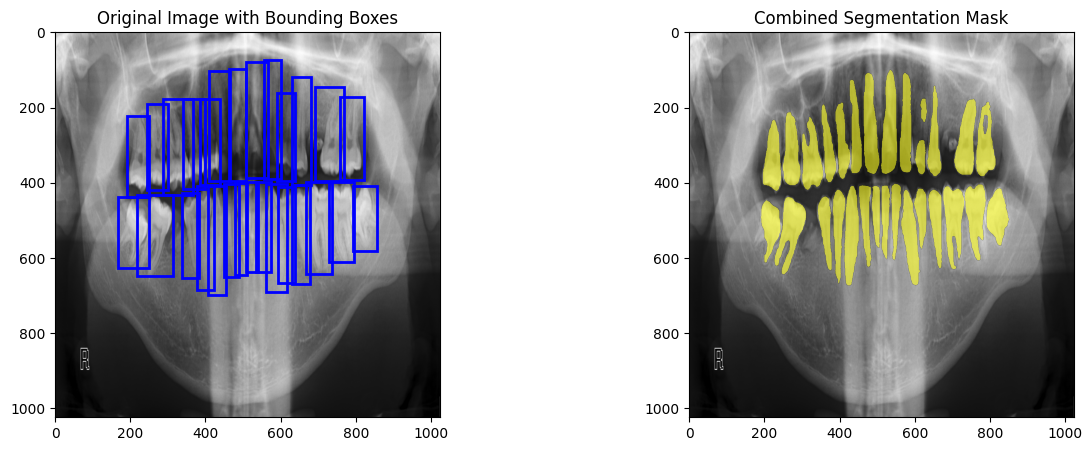

In [ ]:
# Display the combined predicted mask
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Original Image with Bounding Boxes
axs[0].imshow(img_1024)
axs[0].set_title("Original Image with Bounding Boxes")
with open(yolo_annotation_path, 'r') as f:
    for line in f:
        parts = line.strip().split()
        _, x_center, y_center, width, height = map(float, parts)
        x_center_pixel, y_center_pixel = x_center * 1024, y_center * 1024
        width_pixel, height_pixel = width * 1024, height * 1024
        x_min, y_min = x_center_pixel - (width_pixel / 2), y_center_pixel - (height_pixel / 2)
        x_max, y_max = x_center_pixel + (width_pixel / 2), y_center_pixel + (height_pixel / 2)
        show_box([x_min, y_min, x_max, y_max], axs[0])

# Predicted Combined Mask
axs[1].imshow(img_1024, cmap='gray')
show_mask(all_masks, axs[1])
axs[1].set_title("Combined Segmentation Mask")

plt.show()

Dice Score: 0.8424


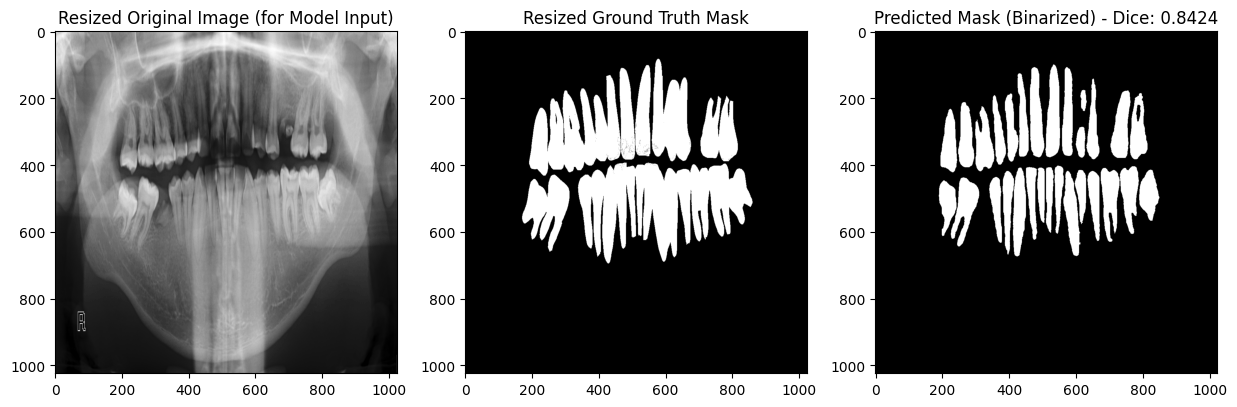

In [ ]:
# Define paths
orig_masks_path = "PATH\TO\Masks"
img_path = "PATH\TO\Image"  

# Load and resize the original image to 1024x1024 for model input
original_image = io.imread(img_path)
resized_image = transform.resize(original_image, (1024, 1024), order=3, preserve_range=True).astype(np.uint8)

# Load and resize the ground truth masks
def load_and_resize_masks(path, target_shape=(1024, 1024)):
    dirs = natsorted(os.listdir(path))
    mask_stack = []
    
    for mask_file in dirs:
        img = Image.open(os.path.join(path, mask_file))
        img = np.asarray(img.convert('L'))  # Convert to grayscale if needed
        img_resized = transform.resize(img, target_shape, order=0, preserve_range=True).astype(np.uint8)
        mask_stack.append(img_resized)
    
    masks = np.stack(mask_stack, axis=0)
    return masks

# Load and prepare the resized ground truth masks
ground_truth_masks = load_and_resize_masks(path=orig_masks_path, target_shape=(1024, 1024))
ground_truth_mask_resized = ground_truth_masks[1]  # Adjust index as needed
predicted_mask = (all_masks > 0).astype(np.uint8) * 255  # Binarize the model's predicted mask

# Define a function to calculate the Dice Score
def compute_dice(pred_mask, gt_mask):
    pred_mask_bin = (pred_mask > 0).astype(np.uint8)
    gt_mask_bin = (gt_mask > 0).astype(np.uint8)
    intersection = np.sum(pred_mask_bin * gt_mask_bin)
    union = np.sum(pred_mask_bin) + np.sum(gt_mask_bin)
    dice_score = (2 * intersection) / union if union > 0 else 1.0
    return dice_score

# Calculate the Dice Score
dice_score = compute_dice(predicted_mask, ground_truth_mask_resized)
print(f"Dice Score: {dice_score:.4f}")

# Display results
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Resized Original Image
axs[0].imshow(resized_image, cmap='gray')
axs[0].set_title("Resized Original Image (for Model Input)")

# Resized Ground Truth Mask
axs[1].imshow(ground_truth_mask_resized, cmap='gray')
axs[1].set_title("Resized Ground Truth Mask")

# Predicted Mask
axs[2].imshow(predicted_mask, cmap='gray')
axs[2].set_title(f"Predicted Mask (Binarized) - Dice: {dice_score:.4f}")

plt.show()